In [35]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from nltk import word_tokenize
from nltk import pos_tag
from nltk import bigrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
RANDOM_SEED = 42

In [8]:
train_df = pd.read_csv('Data/WikiLarge_Train.csv')

In [9]:
pos_bar = {
    'J': 'a',
    'N': 'n',
    'R': 'r',
    'V': 'v'
}

In [10]:
stop = set(stopwords.words('english'))
lem = WordNetLemmatizer()

tokens = []
for s in train_df['original_text']:
    tokens.append(word_tokenize(s))

keeps = []
for s in tokens:
    keeps.append([w for w in s if w.lower() not in stop and w.isalpha()])
    
pos = []
for s in keeps:
    pos.append([w for w in pos_tag(s) if w[0].isalpha() and w[1] != ''])
    


KeyError: 'NN'

In [13]:
lemma = []
for s in pos:
    tmp = []
    for w in s:
        if pos_bar.get(w[1][0], None):
            tmp.append(lem.lemmatize(word=w[0], pos=pos_bar[w[1][0]]))
            
    if len(tmp) == 0:
        lemma.append([])
    else:
        lemma.append(tmp)
    
bigram = []
for s in lemma:
    for b in list(bigrams(s)):
        bigram.append(b)

#### New Features

In [15]:
print(len(train_df))
print(len(tokens))
print(len(keeps))
print(len(pos))
print(len(lemma))
print(len(bigram))

416768
416768
416768
416768
416768
1897933.0


In [16]:
df = train_df

In [17]:
df['word_count'] = [len(i) for i in keeps]
df['avg_word_length'] = [np.mean([len(w) for w in i]) for i in keeps]
df['noun_count'] = [len([w[0] for w in s if w[1].startswith('N')]) for s in pos]
df['verb_count'] = [len([w[0] for w in s if w[1].startswith('V')]) for s in pos]
df['adj_count'] = [len([w[0] for w in s if w[1].startswith('J')]) for s in pos]
df['adv_count'] = [len([w[0] for w in s if w[1].startswith('F')]) for s in pos]
df['cnoun_count'] = [len([w[0] for w in s if w[1]=='NN' or w[1]=='NNS']) for s in pos]
df['pnoun_count'] = [len([w[0] for w in s if w[1]=='NNP']) for s in pos]

C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
G = nx.Graph(bigram)
dc = G.degree

In [29]:
dc = dict(bc)

In [30]:
df['betweenness'] = [np.mean([dc.get(c,0) for c in s]) for s in lemma]

C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\jojuh\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
df.head()

,original_text,label,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,cnoun_count,pnoun_count,betweenness
0,There is manuscript evidence that Austen conti...,1,18,5.722222,12,2,2,0,6,6,1250.611111
1,"In a remarkable comparative analysis , Mandaea...",1,13,7.615385,8,1,3,0,3,5,242.692308
2,"Before Persephone was released to Hermes , who...",1,19,6.631579,8,7,2,0,6,2,758.411765
3,Cogeneration plants are commonly found in dist...,1,27,6.925926,17,5,3,0,17,0,1070.259259
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,9,6.888889,8,0,1,0,3,5,1776.444444


In [41]:
df_clean = df.dropna()

In [42]:
print(len(df))
print(len(df_clean))

416768
415212


In [43]:
features = ['word_count','avg_word_length','noun_count','verb_count',
            'adj_count','adv_count','cnoun_count','pnoun_count','betweenness']

X = np.array(df_clean[features])
y = np.array(df_clean['label'])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

C:\Users\jojuh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [51]:
pca = PCA(n_components=X.shape[1], random_state=42)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [59]:
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 38.55788545,  55.38424463,  68.58856974,  79.54142079,
        88.0766068 ,  94.60111036,  99.81105538,  99.98595276,
       100.        ])

<AxesSubplot:>

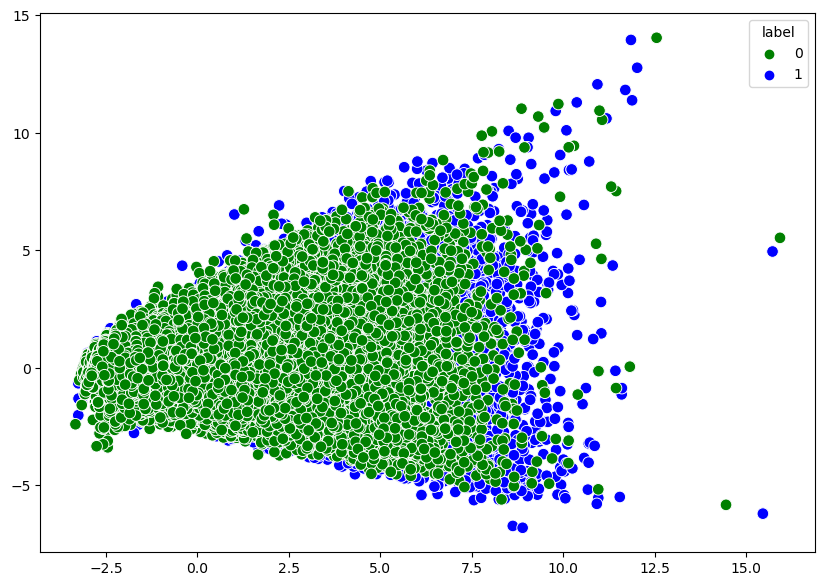

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], s=70, hue=df_clean['label'], palette=['green','blue'])